In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from tqdm import tqdm
sns.set_theme(context='notebook', style='darkgrid', palette="rocket_r")

In [29]:
aisles=pd.read_csv("aisles.csv")
depart=pd.read_csv("departments.csv")
prior=pd.read_csv("order_products__prior.csv")
train=pd.read_csv("order_products__train.csv")
orders=pd.read_csv("orders.csv")
products=pd.read_csv("products.csv")

In [26]:
orders=pd.read_csv("orders.csv")

In [7]:
orders.fillna(value = 0, inplace = True)

In [8]:
prior_orders_data = prior.sort_values(by=['order_id'])
del prior
prior_orders_data = pd.merge(left = prior_orders_data, right = products,
                             left_on='product_id', right_on='product_id').sort_values(by=['order_id']).reset_index(drop=True)
del products
prior_orders_data = pd.merge(left = prior_orders_data, right = aisles,
                             left_on='aisle_id', right_on='aisle_id').sort_values(by=['order_id']).reset_index(drop=True)
del aisles
prior_orders_data = pd.merge(left = prior_orders_data, right = depart,
                             left_on='department_id', right_on='department_id').sort_values(by=['order_id']).reset_index(drop=True)
del depart
prior_orders_data = pd.merge(left = prior_orders_data, right = orders,
                             left_on='order_id', right_on='order_id').sort_values(by=['order_id']).reset_index(drop=True)
del orders

In [9]:
col_order = ['user_id',
 'order_id',
 'product_id',
  'aisle_id',
 'department_id',
 'add_to_cart_order',
 'reordered',
 'product_name',
 'aisle',
 'department',
 'eval_set',
 'order_number',
 'order_dow',
 'order_hour_of_day',
 'days_since_prior_order']

prior_orders_data = prior_orders_data[col_order]
print("Shape of prior_orders_data :", prior_orders_data.shape)
prior_orders_data.head()

Shape of prior_orders_data : (32434489, 15)


,user_id,order_id,product_id,aisle_id,department_id,add_to_cart_order,reordered,product_name,aisle,department,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,202279,2,33120,86,16,1,1,Organic Egg Whites,eggs,dairy eggs,prior,3,5,9,8.0
1,202279,2,1819,88,13,8,1,All Natural No Stir Creamy Almond Butter,spreads,pantry,prior,3,5,9,8.0
2,202279,2,45918,19,13,4,1,Coconut Butter,oils vinegars,pantry,prior,3,5,9,8.0
3,202279,2,9327,104,13,3,0,Garlic Powder,spices seasonings,pantry,prior,3,5,9,8.0
4,202279,2,17794,83,4,6,1,Carrots,fresh vegetables,produce,prior,3,5,9,8.0


Product Based Features

In [10]:
def generate_product_features(prior_data = None):
    
    """
    Generate Product based features and return it as dataframe object.
    Later this dataframe will be merged with other dataframe to generate training data
    
    Features:
    feat_1 : product_reorder_rate       : How Frequently the product was reordered ?
    feat_2 : avg_pos_incart             : Average position of product in the cart ?
    
    next 3 values are calculated based product being 
        - organic, 
        - isYogurt - aisle
        - produce  - department
        - isFrozen  - department 
        - isdairy  - department
        - isbreakfast  - department 
        - issnack  - department
        - isbeverage  - department
    these values are then reduced to 3 columns using Non-Negative Matrix Factorization, to reduce sparsity
        
    feat_3 : p_reduced_feat_1             : column 1 from NMF output
    feat_4 : p_reduced_feat_2             : column 2 from NMF output
    feat_5 : p_reduced_feat_3             : column 3 from NMF output
    feat_6 : aisle_reorder_rate           : How frequently a product is reordered from the aisle to which this product belongs
    feat_7 : department_reorder_rate      : How frequently a product is reordered from the department to which this product belongs
    
    
    """
    
    #create an empty dataframe
    product_features = pd.DataFrame(columns=['product_id'])
    
    #add product_name
    product_features['product_id'] = prior_data['product_id'].sort_values().unique()
    
    #get reorder_rate for each product
    #reorder_rate = reorders / total orders
    df = pd.DataFrame({'reorder_rate': prior_data.groupby(['product_id','reordered'])['reordered'].\
                                                       count().groupby(level=0).\
                                                       apply(lambda x: x / float(x.sum()))}).reset_index()

    #get data of reordered products only
    new_df = df[df['reordered']==1]
    new_df['reorder_rate'] = new_df['reorder_rate'] * new_df['reordered']
    
    #handling for products which were never reordered, hence reorder_rate = 0.0
    new_df_1 = df[(df['reordered']==0) & (df['reorder_rate']==float(1.0))]
    new_df_1['reorder_rate'] = new_df_1['reorder_rate'] * new_df_1['reordered']
    new_df = new_df.append(new_df_1)
    
    #drop other columns of the new_df and sort values by product name to align with product features dataframe
    new_df.drop('reordered', axis = 1, inplace = True)
    new_df.sort_values(by='product_id', inplace =  True)   
    new_df = new_df.reset_index(drop = True)
    
    #add to feat_1 of product_features dataframe
    product_features['product_reorder_rate'] = new_df['reorder_rate']
    
    #get mean position of product in the cart, sort by product_name and add to feat_2 of product_features
    mean_position = prior_data.groupby('product_id')['add_to_cart_order'].mean().reset_index(name = 'mean_position')
    mean_position.sort_values(by = 'product_id', inplace = True)
    product_features['avg_pos_incart'] = mean_position['mean_position']
    
    
    
    #generate boolean values if product belongs to below categories
    products['organic'] = products['product_name'].apply(lambda x: 'organic' in x.lower()).astype(int)
    products['isYogurt'] = products['aisle_id'].apply(lambda x: x==120).astype(int)

    products['isProduce'] = products['department_id'].apply(lambda x: x==4).astype(int)
    products['isFrozen'] = products['department_id'].apply(lambda x: x==1).astype(int)
    products['isdairy'] = products['department_id'].apply(lambda x: x==16).astype(int)
    products['isbreakfast'] = products['department_id'].apply(lambda x: x==14).astype(int)
    products['issnack'] = products['department_id'].apply(lambda x: x==19).astype(int)
    products['isbeverage'] = products['department_id'].apply(lambda x: x==7).astype(int)

    new_product_feat = products[['organic', 'isYogurt', 'isProduce', 'isFrozen', 'isdairy', 'isbreakfast', 'issnack', 'isbeverage']]
    
    #reduce sparsity using NMF
    #ref:https://www.kaggle.com/themissingsock/matrix-decomposition-with-buyer-data
    from sklearn.decomposition import NMF
    from sklearn.preprocessing import normalize

    nmf = NMF(n_components = 3)
    model = nmf.fit(new_product_feat)
    W = model.transform(new_product_feat)
    prod_data = pd.DataFrame(normalize(W))

    prod_data.columns = ['p_reduced_feat_1', 'p_reduced_feat_2','p_reduced_feat_3']
    products.drop(['organic', 'isYogurt', 'isProduce', 'isFrozen', 'isdairy', 'isbreakfast', 'issnack', 'isbeverage'], axis = 1, inplace =True)

    product_features['p_reduced_feat_1'] = prod_data['p_reduced_feat_1']
    product_features['p_reduced_feat_2'] = prod_data['p_reduced_feat_2']
    product_features['p_reduced_feat_3'] = prod_data['p_reduced_feat_3']
    

    #Get aisle reorder rate
    df = prior_data.groupby(['aisle']).size().reset_index(name='order_count')
    aisle_reorder_rate = prior_data[prior_data['reordered']==1].groupby(['aisle']).size().reset_index(name='reorder_rate')
    df['aisle_reorder_rate'] = aisle_reorder_rate['reorder_rate']/df['order_count']
    df.drop(['order_count'], axis = 1, inplace = True)
    new_df = pd.merge(prior_data, df, on = 'aisle')
    
    
    #Get dept reorder rate
    df = prior_data.groupby(['department']).size().reset_index(name='order_count')
    aisle_reorder_rate = prior_data[prior_data['reordered']==1].groupby(['aisle']).size().reset_index(name='reorder_rate')
    df['dept_reorder_rate'] = aisle_reorder_rate['reorder_rate']/df['order_count']
    df.drop(['order_count'], axis = 1, inplace = True)
    new_df = pd.merge(new_df, df, on = 'department')
    
    new_df = new_df[['product_id','aisle_id','department_id','aisle_reorder_rate','dept_reorder_rate']]
    new_df.drop_duplicates(keep='first', inplace = True)

    #merge dept_reorder_rate and aisle_reorder_rate to existing product features
    product_features = pd.merge(product_features, new_df , on='product_id', how = 'inner')
    
    del df, new_df, new_df_1, new_product_feat, model, prod_data
    return product_features

In [13]:
%%time
product_features = generate_product_features(prior_data = prior_orders_data )
product_features.head()

C:\Users\Prashant\AppData\Local\Temp\ipykernel_8220\4005876159.py:41: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  apply(lambda x: x / float(x.sum()))}).reset_index()
C:\Users\Prashant\AppData\Local\Temp\ipykernel_8220\4005876159.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['reorder_rate'] = new_df['reorder_rate'] * new_df['reordered']
C:\Users\Prashant\AppData\Local\Temp\ipykernel_822

CPU times: total: 3min 3s
Wall time: 5min 41s


,product_id,product_reorder_rate,avg_pos_incart,p_reduced_feat_1,p_reduced_feat_2,p_reduced_feat_3,aisle_id,department_id,aisle_reorder_rate,dept_reorder_rate
0,1,0.613391,5.801836,1.0,0.0,0.0,61,19,0.548698,0.043323
1,2,0.133333,9.888889,0.0,0.0,0.0,104,13,0.152391,0.031986
2,3,0.732852,6.415162,0.0,0.0,1.0,94,7,0.527615,0.000943
3,4,0.446809,9.507599,0.0,1.0,0.0,38,1,0.556655,0.006004
4,5,0.600000,6.466667,0.0,0.0,0.0,5,13,0.280627,0.031986


In [14]:
product_features.to_csv("product_features_v6.csv",index=False)

User Based Features

In [15]:
def generate_user_features(prior_data = None):
    
    """
    Generate User based features and return it as dataframe object.
    Later this dataframe will be merged with other dataframe like product features to generate training data
    
    Features:
    feat_1 : user_reorder_rate              : Average reorder rate on orders placed?
    feat_2 : user_unique_products           : Distinct Products ordered ?
    feat_3 : user_total_products            : Total products ordered ?
    feat_4 : user_avg_cart_size             : mean Products per order ? = average cart size ?
    feat_5 : user_avg_days_between_orders   : Average days between orders ?
    feat_6 : user_reordered_products_ratio  : user product reorder ratio
    
    """
    
    #create an empty dataframe
    user_features = pd.DataFrame(columns=['user_id'])
    
    #Add user_id
    user_features['user_id'] = prior_data['user_id'].sort_values().unique()
    
    # Get mean reorder rate for every user
    # Process :
    #  1. Count reorders for every user_id using reordered feature of prior_train_orders
    #  2. Perform Groupby on this output using user_id and get prob of reorder == 0 and reorder == 1
    #  3. Seperate reorder == 0 and reorder == 1 using pivot and fill 0 , where reorder==1 is NA ( indicating no reorders)
    #  4. Add reorder == 1 column to feat_1 
    
    user_reorder_rate = prior_data.groupby(["user_id","reordered"])['reordered'].count().groupby(level = 0).apply(lambda x: x / float(x.sum())).reset_index(name='reorder_rate')
    user_reorder_rate = user_reorder_rate.pivot(index ='user_id', columns ='reordered', values =['reorder_rate']) 
    user_reorder_rate = pd.DataFrame(user_reorder_rate.to_records())
    user_reorder_rate.columns = ['user_id','0', '1']
    user_reorder_rate.set_index("user_id", inplace = True)
    user_reorder_rate.fillna(0, inplace = True)
    user_reorder_rate.reset_index(inplace = True)
    user_features['user_reorder_rate'] = user_reorder_rate['1']
    
    #Get count of all unique products for every user
    user_features['user_unique_products'] = prior_data.groupby(["user_id"])['product_name'].nunique().reset_index(name = 'unique')['unique']
    
    #Get count of all products ordered by user
    user_features['user_total_products'] = prior_data.groupby(["user_id"])['product_name'].size().reset_index(name = 'count')['count']
    
    #Get mean products per user = Average cart size of user
    df = prior_data.groupby(["user_id","order_id"])['add_to_cart_order'].count().reset_index(name='cart_size')\
                                                                .groupby('user_id')['cart_size'].mean().reset_index()
    user_features['user_avg_cart_size'] = df['cart_size']
    
    #Get average days between 2 orders for every user
    df = prior_data.groupby(["user_id","order_id"])['days_since_prior_order'].max().reset_index(name='mean_days_between_orders')\
                                                                .groupby('user_id')['mean_days_between_orders'].mean().reset_index()
    user_features['user_avg_days_between_orders'] = df['mean_days_between_orders']
    
    
    #get user product reorder ratio 
    # number of unique products reordered / number of unique products ordered
    df['user_id'] = prior_data['user_id'].sort_values().unique()
    df['user_unique_products'] = prior_data.groupby(["user_id"])['product_name'].nunique().reset_index(name = 'unique')['unique']
    df['user_reordered_products'] = prior_data[prior_data['reordered']==1].groupby(["user_id"])['product_name'].nunique().reset_index(name = 'reordered_unique')['reordered_unique']
    df.fillna(0, inplace = True)
    user_features['user_reordered_products_ratio'] = df['user_reordered_products'] / df['user_unique_products']
    
    del df
    return user_features



In [16]:
user_features = generate_user_features(prior_data = prior_orders_data)
user_features.to_csv("user_features_v6.csv",index=False)

C:\Users\Prashant\AppData\Local\Temp\ipykernel_8220\2148210309.py:30: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  user_reorder_rate = prior_data.groupby(["user_id","reordered"])['reordered'].count().groupby(level = 0).apply(lambda x: x / float(x.sum())).reset_index(name='reorder_rate')


User Product Features

In [17]:
def max_streak(row):
    
    """
    Function to calculate the maximum number of orders in a row which contains reorders of a product
    
    inp: pandas row
    output: max orders
    """
    _max = 0
    _sum = 0
    for i in row:
        if i==1:
            _sum += 1
        else:
            if _sum > _max:
                _max = _sum
            _sum = 0 
    return _max

In [18]:
def generate_user_product_features(prior_data = None):
    
    """
    Generate User-Product interaction features and return it as dataframe object.
    Later this dataframe will be merged with other dataframe like product features and user features to generate training data
    
    Features:
    feat_1 : u_p_order_rate             :  How frequently user ordered the product ?
    feat_2 : u_p_reorder_rate           :  How frequently user reordered the product ?
    feat_3 : u_p_avg_position           :  Average position of product in the cart on orders placed by user ?
    feat_4 : u_p_orders_since_last      :  Number of orders placed since the product was last ordered ?
    feat_5 : max_streak                 :  Number of orders where user continuously brought a product without miss
    """
    

    #create an empty dataframe
    user_product_features = pd.DataFrame(columns=['user_id','product_id'])
    
    #get unique user-product pairs ( total data is reduced by 60 %)
    #prior_train_orders.groupby(["user_id","product_id"]).size().shape[0]/prior_train_orders.shape[0]  - 0.409
    #add user and product to dataframe
    u_p = prior_data.groupby(["user_id","product_id"]).size().reset_index()
    user_product_features["user_id"] = u_p["user_id"]
    user_product_features["product_id"] = u_p["product_id"]
    
    #How frequently user ordered the product ?
    # #times user ordered the product/ #times user placed an order
    df = prior_data.groupby(["user_id","product_id"])["reordered"].size()
    df = df/prior_data.groupby(["user_id"]).size()
    df = df.reset_index(name = 'order_rate')
    df.fillna(0. , inplace = True)
    user_product_features["u_p_order_rate"] = df["order_rate"]
    
    #How frequently user reordered the product ?
    # #times user reordered the product/ #times user ordered the product
    df = prior_data[prior_data["reordered"]==1].groupby(["user_id","product_id"])["reordered"].size()
    df = df/prior_data.groupby(["user_id","product_id"]).size()
    df = df.reset_index(name = 'reorder_rate')
    df.fillna(0. , inplace = True)
    user_product_features["u_p_reorder_rate"] = df["reorder_rate"]
    
    #Average position of product in the cart on orders placed by user ?
    
    df = prior_data.groupby(["user_id","product_id"])['add_to_cart_order'].mean().reset_index(name = 'mean_position')
    user_product_features['u_p_avg_position'] = df['mean_position']

    
    #Number of orders placed since the product was last ordered ?
    # Get last order_number placed by user , subtract with last order_number with the product in cart 
    
    df = prior_data.groupby(["user_id","product_id"])['order_number'].max().reset_index()
    df_2 = prior_data.groupby(["user_id"])['order_number'].max().reset_index()
    new_df = pd.merge(df, df_2,  how='outer', left_on=['user_id'], right_on = ['user_id'])        
    new_df['order_diff'] = new_df['order_number_y'] - new_df['order_number_x']
    user_product_features['u_p_orders_since_last'] = new_df['order_diff']
    
    #max_streak
    df = prior_data.groupby(["user_id","product_id"])['reordered'].apply(list).reset_index(name = 'max_streak')
    df['max_streak'] = df['max_streak'].apply(max_streak)
    user_product_features = pd.merge(user_product_features, df, on= ["user_id","product_id"])
    #user_features["max_streak"] = df['reorder_summary'].apply(max_streak) 
    
    
    del df, new_df, df_2
    return user_product_features


In [19]:
user_product_features = generate_user_product_features(prior_data = prior_orders_data)
user_product_features.to_csv("user_product_features_prior_data_v6.csv",index=False)

Time Conversion

In [20]:
def hour_tocategorical(time):
    """
    convert hour of the day to categorical feature
    """
    if time > 5 and time < 12:
            return 0
    elif time > 12 and time < 17:
        return 1
    elif time > 17 and time < 21:
        return 2
    else:
        return 3

Misc Features

In [21]:
def product_time(prior_data = None):
    
    """
    feature : how frequently product was reordered on any given hour ?
    """
    df = prior_data.groupby(['product_id','order_hour_of_day'])["reordered"].size()
    df = df/prior_data.groupby(["product_id"]).size()
    df = df.reset_index(name = 'hour_reorder_rate')
    return df

def product_day(prior_data = None):
    """
    feature: how frequently product was reordered on any given day ?
    """
    df = prior_data.groupby(['product_id','order_dow'])["reordered"].size()
    df = df/prior_data.groupby(["product_id"]).size()
    df = df.reset_index(name = 'day_reorder_rate')
    return df

def product_days_since_prior(prior_data = None):
    """
    feature: how frequently a product was reordered  given that 
            difference between 2 orders containing product in days ?
    """
    df = prior_data.groupby(['product_id','days_since_prior_order'])["reordered"].size()
    df = df/prior_data.groupby(["product_id"]).size()
    df = df.reset_index(name = 'p_days_since_prior_order_reorder_rate')
    return df

def user_days_since_prior(prior_data = None):
    """
    feature: how frequently user reordered any product given difference between 2 orders in days ?
    """
    df = prior_data.groupby(['user_id','days_since_prior_order'])["reordered"].size()
    df = df/prior_data.groupby(["user_id"]).size()
    df = df.reset_index(name = 'u_days_since_prior_order_reorder_rate')
    return df

def u_p_days_since_prior(prior_data = None):
    """
    feature: how frequently user reordered a particular product given difference between 2 orders in days ?
    """
    df = prior_data.groupby(["user_id","product_id","days_since_prior_order"])["reordered"].size()
    df = df/prior_data.groupby(["user_id","product_id"]).size()
    df = df.reset_index(name = 'days_since_prior_reorder_rate')
    return df

In [22]:
#construct dataframe

hour_reorder_rate = product_time(prior_orders_data)
day_reorder_rate = product_day(prior_orders_data)
p_days_since_prior_order_reorder_rate = product_days_since_prior(prior_orders_data)
u_days_since_prior_order_reorder_rate = user_days_since_prior(prior_orders_data)
days_since_prior_reorder_rate = u_p_days_since_prior(prior_orders_data)
#save these files

hour_reorder_rate.to_csv("hour_reorder_rate.csv", index = False)
day_reorder_rate.to_csv("day_reorder_rate.csv", index = False)
p_days_since_prior_order_reorder_rate.to_csv("p_days_since_prior_order_reorder_rate.csv", index = False)
u_days_since_prior_order_reorder_rate.to_csv("u_days_since_prior_order_reorder_rate.csv", index = False)
days_since_prior_reorder_rate.to_csv("days_since_prior_reorder_rate.csv", index = False)

In [23]:
product_features = pd.read_csv("product_features_v6.csv")
user_features = pd.read_csv("user_features_v6.csv")
user_product_features = pd.read_csv("user_product_features_prior_data_v6.csv")

In [24]:
gc.collect()

0

Generate Training Data

In [27]:
merged_df = pd.merge(user_product_features, user_features,  how='outer', left_on=['user_id'], right_on = ['user_id'])
merged_df = pd.merge(merged_df, product_features,  how='outer', left_on=['product_id'], right_on = ['product_id'])
merged_df.to_csv('merged_user_product_features.csv',index=False)
order_details_train = orders[orders['eval_set'] == 'train']
order_details_train

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
10,1187899,1,train,11,4,8,14.0
25,1492625,2,train,15,1,11,30.0
49,2196797,5,train,5,0,11,6.0
74,525192,7,train,21,2,11,6.0
78,880375,8,train,4,1,14,10.0
...,...,...,...,...,...,...,...
3420838,2585586,206199,train,20,2,16,30.0
3420862,943915,206200,train,24,6,19,6.0
3420924,2371631,206203,train,6,4,19,30.0
3420933,1716008,206205,train,4,1,16,10.0


In [ ]:
train_order_data = train.sort_values(by=['order_id'])
train_order_data = pd.merge(left = train_order_data, right = products,
                             left_on='product_id', right_on='product_id').sort_values(by=['order_id']).reset_index(drop=True)
train_order_data = pd.merge(left = train_order_data, right = aisles,
                             left_on='aisle_id', right_on='aisle_id').sort_values(by=['order_id']).reset_index(drop=True)
train_order_data = pd.merge(left = train_order_data, right = depart,
                             left_on='department_id', right_on='department_id').sort_values(by=['order_id']).reset_index(drop=True)
train_order_data = pd.merge(left = train_order_data, right = orders,
                             left_on='order_id', right_on='order_id').sort_values(by=['order_id']).reset_index(drop=True)

col_order = ['user_id',
 'order_id',
 'product_id',
  'aisle_id',
 'department_id',
 'add_to_cart_order',
 'reordered',
 'product_name',
 'aisle',
 'department',
 'eval_set',
 'order_number',
 'order_dow',
 'order_hour_of_day',
 'days_since_prior_order']

train_order_data = train_order_data[col_order]
print("Shape of train_order_data :", train_order_data.shape)
train_order_data.head()

In [ ]:
upd_train_orders = train_order_data[['user_id','order_id','product_id','reordered']]
last_orders = upd_train_orders.groupby(['user_id'])['order_id'].max().reset_index(name = 'new_order_id')
order_details = train_order_data[['order_id','order_dow','order_hour_of_day','days_since_prior_order']]
order_details = order_details.drop_duplicates()

In [ ]:
train_orders_merged_df = pd.merge(merged_df, upd_train_orders,  how='left', left_on=['user_id','product_id'], right_on = ['user_id','product_id'])
train_orders_merged_df = pd.merge(train_orders_merged_df, last_orders, on = 'user_id')
train_orders_merged_df.drop("order_id", axis = 1, inplace = True)
train_orders_merged_df.rename(columns = {'new_order_id':'order_id'}, inplace = True) 
train_orders_merged_df = pd.merge(train_orders_merged_df, order_details, on = 'order_id')
train_orders_merged_df[['reordered']]= train_orders_merged_df[['reordered']].fillna(value=0.0)


In [ ]:
train_orders_merged_df = pd.merge(train_orders_merged_df, hour_reorder_rate, on=['product_id','order_hour_of_day'], how = 'left')
train_orders_merged_df[['hour_reorder_rate']]= train_orders_merged_df[['hour_reorder_rate']].fillna(value=0.0)

train_orders_merged_df = pd.merge(train_orders_merged_df, day_reorder_rate, on=['product_id','order_dow'], how = 'left')
train_orders_merged_df[['day_reorder_rate']]= train_orders_merged_df[['day_reorder_rate']].fillna(value=0.0)

train_orders_merged_df = pd.merge(train_orders_merged_df, p_days_since_prior_order_reorder_rate, on=['product_id','days_since_prior_order'], how = 'left')
train_orders_merged_df[['p_days_since_prior_order_reorder_rate']]= train_orders_merged_df[['p_days_since_prior_order_reorder_rate']].fillna(value=0.0)

train_orders_merged_df = pd.merge(train_orders_merged_df, u_days_since_prior_order_reorder_rate, on=['user_id','days_since_prior_order'], how = 'left')
train_orders_merged_df[['u_days_since_prior_order_reorder_rate']]= train_orders_merged_df[['u_days_since_prior_order_reorder_rate']].fillna(value=0.0)

train_orders_merged_df = pd.merge(train_orders_merged_df, days_since_prior_reorder_rate, on=["user_id","product_id",'days_since_prior_order'], how = 'left')
train_orders_merged_df[['days_since_prior_reorder_rate']]= train_orders_merged_df[['days_since_prior_reorder_rate']].fillna(value=0.0)


In [ ]:
train_orders_merged_df = train_orders_merged_df[['user_id', 'product_id', 'u_p_order_rate', 'u_p_reorder_rate', 'u_p_avg_position', 'u_p_orders_since_last', 'max_streak', 'user_reorder_rate', 'user_unique_products', 'user_total_products', 'user_avg_cart_size', 'user_avg_days_between_orders', 'user_reordered_products_ratio', 'product_reorder_rate', 'avg_pos_incart', 'p_reduced_feat_1', 'p_reduced_feat_2', 'p_reduced_feat_3', 'aisle_id', 'department_id', 'aisle_reorder_rate', 'dept_reorder_rate', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'hour_reorder_rate', 'day_reorder_rate', 'p_days_since_prior_order_reorder_rate', 'u_days_since_prior_order_reorder_rate', 'days_since_prior_reorder_rate', 'order_id','reordered']]


In [ ]:
train_orders_merged_df['order_hour_of_day'] = train_orders_merged_df['order_hour_of_day'].apply(hour_tocategorical)


In [ ]:
train_orders_merged_df['user_id'] = train_orders_merged_df['user_id'].astype('int32')
train_orders_merged_df['product_id'] = train_orders_merged_df['product_id'].astype('uint16')
train_orders_merged_df['u_p_order_rate'] = train_orders_merged_df['u_p_order_rate'].astype('float16')
train_orders_merged_df['u_p_reorder_rate'] = train_orders_merged_df['u_p_reorder_rate'].astype('float16')
train_orders_merged_df['u_p_avg_position'] = train_orders_merged_df['u_p_avg_position'].astype('float16')
train_orders_merged_df['u_p_orders_since_last'] = train_orders_merged_df['u_p_orders_since_last'].astype('int8')
train_orders_merged_df['max_streak'] = train_orders_merged_df['max_streak'].astype('int8')
train_orders_merged_df['user_reorder_rate'] = train_orders_merged_df['user_reorder_rate'].astype('float16')
train_orders_merged_df['user_unique_products'] = train_orders_merged_df['user_unique_products'].astype('int16')
train_orders_merged_df['user_total_products'] = train_orders_merged_df['user_total_products'].astype('int16')
train_orders_merged_df['user_avg_cart_size'] = train_orders_merged_df['user_avg_cart_size'].astype('float16')
train_orders_merged_df['user_avg_days_between_orders'] = train_orders_merged_df['user_avg_days_between_orders'].astype('float16')
train_orders_merged_df['user_reordered_products_ratio'] = train_orders_merged_df['user_reordered_products_ratio'].astype('float16')
train_orders_merged_df['product_reorder_rate'] = train_orders_merged_df['product_reorder_rate'].astype('float16')
train_orders_merged_df['avg_pos_incart'] = train_orders_merged_df['avg_pos_incart'].astype('float16')
train_orders_merged_df['p_reduced_feat_1'] = train_orders_merged_df['p_reduced_feat_1'].astype('float16')
train_orders_merged_df['p_reduced_feat_2'] = train_orders_merged_df['p_reduced_feat_2'].astype('float16')
train_orders_merged_df['p_reduced_feat_3'] = train_orders_merged_df['p_reduced_feat_3'].astype('float16')
train_orders_merged_df['aisle_id'] = train_orders_merged_df['aisle_id'].astype('uint8')
train_orders_merged_df['department_id'] = train_orders_merged_df['department_id'].astype('uint8')
train_orders_merged_df['aisle_reorder_rate'] = train_orders_merged_df['aisle_reorder_rate'].astype('float16')
train_orders_merged_df['dept_reorder_rate'] = train_orders_merged_df['dept_reorder_rate'].astype('float16')
train_orders_merged_df['order_dow'] = train_orders_merged_df['order_dow'].astype('uint8')
train_orders_merged_df['order_hour_of_day'] = train_orders_merged_df['order_hour_of_day'].astype('uint8')
train_orders_merged_df['days_since_prior_order'] = train_orders_merged_df['days_since_prior_order'].astype('uint8')
train_orders_merged_df['hour_reorder_rate'] = train_orders_merged_df['hour_reorder_rate'].astype('float32')
train_orders_merged_df['day_reorder_rate'] = train_orders_merged_df['day_reorder_rate'].astype('float32')
train_orders_merged_df['p_days_since_prior_order_reorder_rate'] = train_orders_merged_df['p_days_since_prior_order_reorder_rate'].astype('float32')
train_orders_merged_df['u_days_since_prior_order_reorder_rate'] = train_orders_merged_df['u_days_since_prior_order_reorder_rate'].astype('float32')
train_orders_merged_df['days_since_prior_reorder_rate'] = train_orders_merged_df['days_since_prior_reorder_rate'].astype('float32')
train_orders_merged_df['order_id'] = train_orders_merged_df['order_id'].astype('int32')


In [ ]:
train_orders_merged_df[train_orders_merged_df.columns[:]].corr()['reordered'][:]


user_id                                 -0.000429
product_id                               0.002786
u_p_order_rate                           0.240855
u_p_reorder_rate                         0.247972
u_p_avg_position                        -0.042599
u_p_orders_since_last                   -0.176801
max_streak                               0.204952
user_reorder_rate                        0.007098
user_unique_products                    -0.098347
user_total_products                     -0.059297
user_avg_cart_size                       0.049083
user_avg_days_between_orders             0.059138
user_reordered_products_ratio            0.054655
product_reorder_rate                     0.167353
avg_pos_incart                          -0.129350
p_reduced_feat_1                        -0.007497
p_reduced_feat_2                         0.007396
p_reduced_feat_3                        -0.002960
aisle_id                                 0.002256
department_id                           -0.033707


In [ ]:
from sys import getsizeof
print('Dataframe size: %2.2f GB'%(getsizeof(train_orders_merged_df)/(1024.0**3)))


Dataframe size: 0.67 GB


In [ ]:
train_orders_merged_df.to_hdf("Data_v2.h5", "train", append=True) #0.73GB -> hdf5 doesnt reset the updated dtypes
train_orders_merged_df.to_pickle("train_orders_merged_df_v6.pkl") #0.7GB  -> same here
train_orders_merged_df.to_csv("train_orders_merged_df_v6.csv",index=False) #1.5 GB -> to_csv resets to default dtypes


Featurize Test Data

In [ ]:
order_details_test = orders[orders['eval_set'] == 'test']
order_details_test.drop(['eval_set'], axis = 1, inplace = True)

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\676654858.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_details_test.drop(['eval_set'], axis = 1, inplace = True)


In [ ]:
test_orders_merge_df = pd.merge(order_details_test, user_product_features, on = ['user_id'], how = 'outer')
test_orders_merge_df.dropna(inplace =True)
test_orders_merge_df = pd.merge(test_orders_merge_df, user_features, on = ['user_id'])
test_orders_merge_df = pd.merge(test_orders_merge_df, product_features, on = ['product_id'])


In [ ]:
test_orders_merge_df = pd.merge(test_orders_merge_df, hour_reorder_rate, on=['product_id','order_hour_of_day'], how = 'left')
test_orders_merge_df[['hour_reorder_rate']]= test_orders_merge_df[['hour_reorder_rate']].fillna(value=0.0)

test_orders_merge_df = pd.merge(test_orders_merge_df, day_reorder_rate, on=['product_id','order_dow'], how = 'left')
test_orders_merge_df[['day_reorder_rate']]= test_orders_merge_df[['day_reorder_rate']].fillna(value=0.0)

test_orders_merge_df = pd.merge(test_orders_merge_df, p_days_since_prior_order_reorder_rate, on=['product_id','days_since_prior_order'], how = 'left')
test_orders_merge_df[['p_days_since_prior_order_reorder_rate']]= test_orders_merge_df[['p_days_since_prior_order_reorder_rate']].fillna(value=0.0)

test_orders_merge_df = pd.merge(test_orders_merge_df, u_days_since_prior_order_reorder_rate, on=['user_id','days_since_prior_order'], how = 'left')
test_orders_merge_df[['u_days_since_prior_order_reorder_rate']]= test_orders_merge_df[['u_days_since_prior_order_reorder_rate']].fillna(value=0.0)

test_orders_merge_df = pd.merge(test_orders_merge_df, days_since_prior_reorder_rate, on=["user_id","product_id",'days_since_prior_order'], how = 'left')
test_orders_merge_df[['days_since_prior_reorder_rate']]= test_orders_merge_df[['days_since_prior_reorder_rate']].fillna(value=0.0)


In [ ]:
test_orders_merge_df['order_hour_of_day'] = test_orders_merge_df['order_hour_of_day'].apply(hour_tocategorical)
test_orders_merge_df = test_orders_merge_df[['user_id', 'product_id', 'u_p_order_rate', 'u_p_reorder_rate', 'u_p_avg_position', 'u_p_orders_since_last', 'max_streak', 'user_reorder_rate', 'user_unique_products', 'user_total_products', 'user_avg_cart_size', 'user_avg_days_between_orders', 'user_reordered_products_ratio', 'product_reorder_rate', 'avg_pos_incart', 'p_reduced_feat_1', 'p_reduced_feat_2', 'p_reduced_feat_3', 'aisle_id', 'department_id', 'aisle_reorder_rate', 'dept_reorder_rate', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'hour_reorder_rate', 'day_reorder_rate', 'p_days_since_prior_order_reorder_rate', 'u_days_since_prior_order_reorder_rate', 'days_since_prior_reorder_rate', 'order_id']]


In [ ]:
test_orders_merge_df['user_id'] = test_orders_merge_df['user_id'].astype('int32')
test_orders_merge_df['product_id'] = test_orders_merge_df['product_id'].astype('uint16')
test_orders_merge_df['u_p_order_rate'] = test_orders_merge_df['u_p_order_rate'].astype('float16')
test_orders_merge_df['u_p_reorder_rate'] = test_orders_merge_df['u_p_reorder_rate'].astype('float16')
test_orders_merge_df['u_p_avg_position'] = test_orders_merge_df['u_p_avg_position'].astype('float16')
test_orders_merge_df['u_p_orders_since_last'] = test_orders_merge_df['u_p_orders_since_last'].astype('int8')
test_orders_merge_df['max_streak'] = test_orders_merge_df['max_streak'].astype('int8')
test_orders_merge_df['user_reorder_rate'] = test_orders_merge_df['user_reorder_rate'].astype('float16')
test_orders_merge_df['user_unique_products'] = test_orders_merge_df['user_unique_products'].astype('int16')
test_orders_merge_df['user_total_products'] = test_orders_merge_df['user_total_products'].astype('int16')
test_orders_merge_df['user_avg_cart_size'] = test_orders_merge_df['user_avg_cart_size'].astype('float16')
test_orders_merge_df['user_avg_days_between_orders'] = test_orders_merge_df['user_avg_days_between_orders'].astype('float16')
test_orders_merge_df['user_reordered_products_ratio'] = test_orders_merge_df['user_reordered_products_ratio'].astype('float16')
test_orders_merge_df['product_reorder_rate'] = test_orders_merge_df['product_reorder_rate'].astype('float16')
test_orders_merge_df['avg_pos_incart'] = test_orders_merge_df['avg_pos_incart'].astype('float16')
test_orders_merge_df['p_reduced_feat_1'] = test_orders_merge_df['p_reduced_feat_1'].astype('float16')
test_orders_merge_df['p_reduced_feat_2'] = test_orders_merge_df['p_reduced_feat_2'].astype('float16')
test_orders_merge_df['p_reduced_feat_3'] = test_orders_merge_df['p_reduced_feat_3'].astype('float16')
test_orders_merge_df['aisle_id'] = test_orders_merge_df['aisle_id'].astype('uint8')
test_orders_merge_df['department_id'] = test_orders_merge_df['department_id'].astype('uint8')
test_orders_merge_df['aisle_reorder_rate'] = test_orders_merge_df['aisle_reorder_rate'].astype('float16')
test_orders_merge_df['dept_reorder_rate'] = test_orders_merge_df['dept_reorder_rate'].astype('float16')
test_orders_merge_df['order_dow'] = test_orders_merge_df['order_dow'].astype('uint8')
test_orders_merge_df['order_hour_of_day'] = test_orders_merge_df['order_hour_of_day'].astype('uint8')
test_orders_merge_df['days_since_prior_order'] = test_orders_merge_df['days_since_prior_order'].astype('uint8')
test_orders_merge_df['hour_reorder_rate'] = test_orders_merge_df['hour_reorder_rate'].astype('float16')
test_orders_merge_df['day_reorder_rate'] = test_orders_merge_df['day_reorder_rate'].astype('float16')
test_orders_merge_df['p_days_since_prior_order_reorder_rate'] = test_orders_merge_df['p_days_since_prior_order_reorder_rate'].astype('float32')
test_orders_merge_df['u_days_since_prior_order_reorder_rate'] = test_orders_merge_df['u_days_since_prior_order_reorder_rate'].astype('float32')
test_orders_merge_df['days_since_prior_reorder_rate'] = test_orders_merge_df['days_since_prior_reorder_rate'].astype('float32')
test_orders_merge_df['order_id'] = test_orders_merge_df['order_id'].astype('int32')


In [ ]:
print('Dataframe size: %2.2f GB'%(getsizeof(test_orders_merge_df)/(1024.0**3)))


Dataframe size: 0.33 GB


In [ ]:
test_orders_merge_df.to_hdf("Data_v2.h5", "test", append=True) #1.08GB
test_orders_merge_df.to_pickle("test_orders_merge_df_v6.pkl") #0.35GB
test_orders_merge_df.to_csv("test_orders_merge_df_v6.csv",index=False) #0.79 GB


Analysis of extracted features

In [ ]:
df = pd.read_csv("train_orders_merged_df_v6.csv")

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

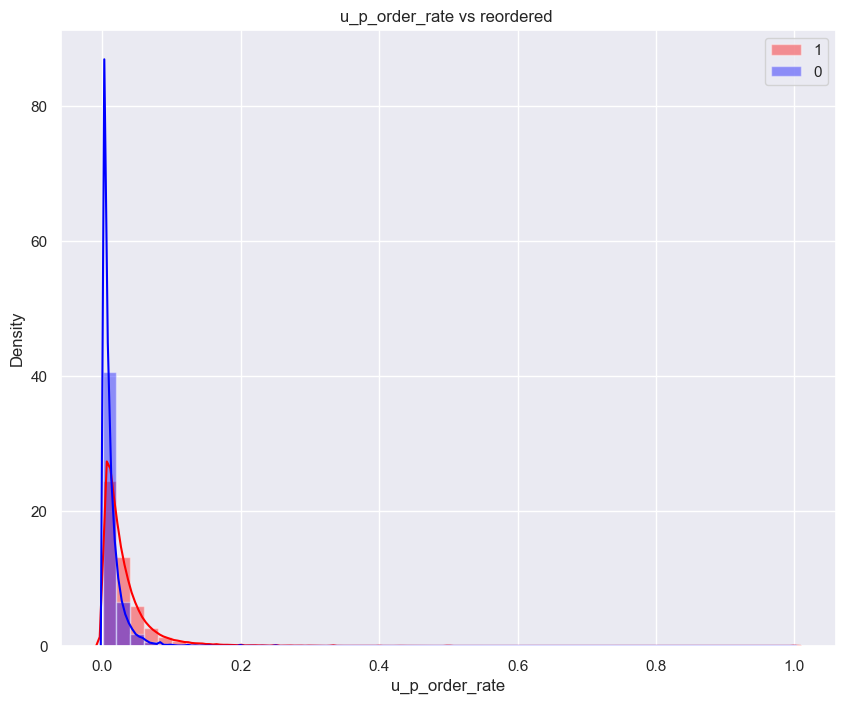

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

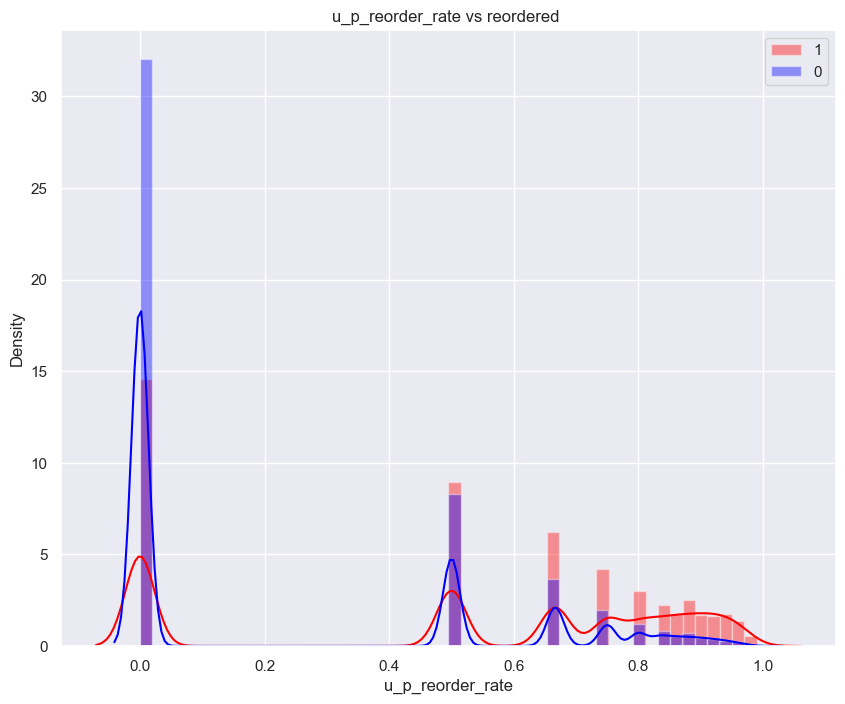

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

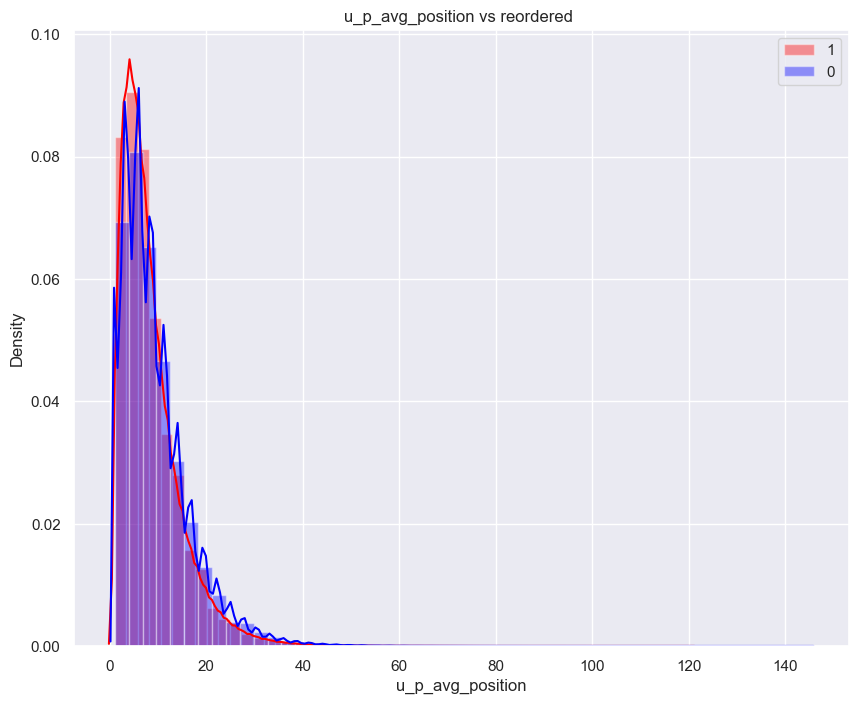

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

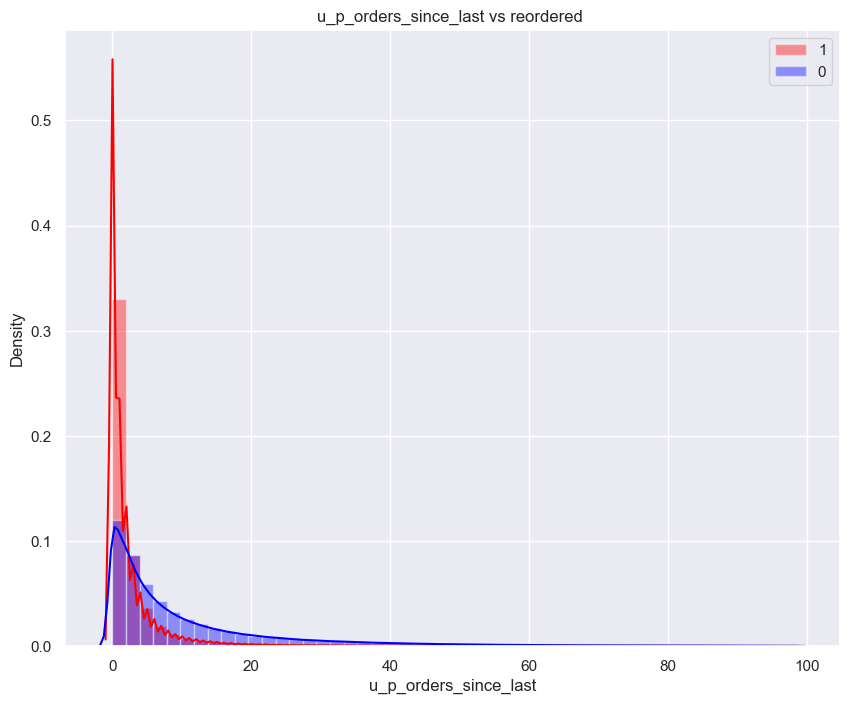

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

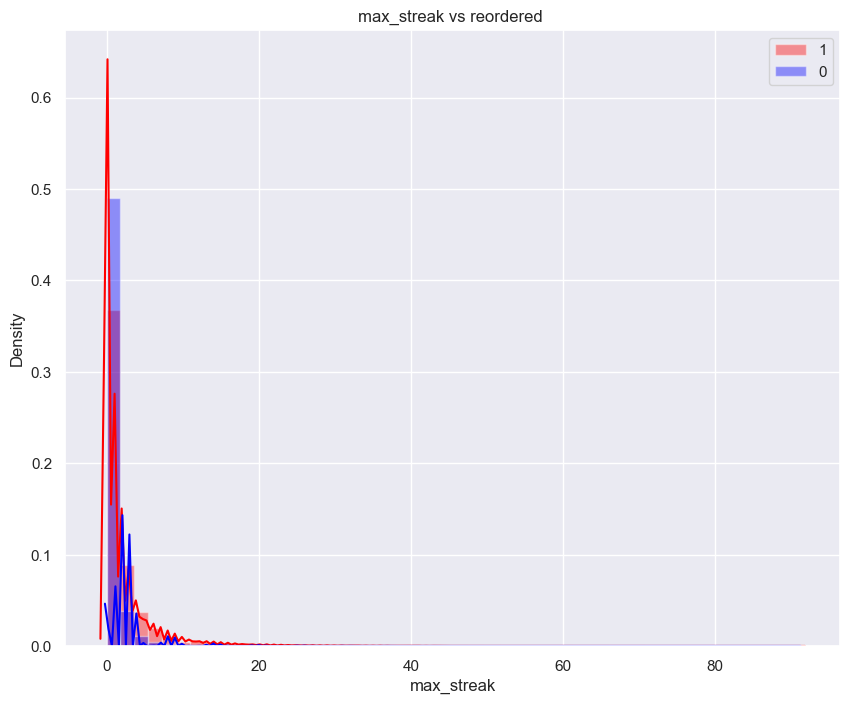

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

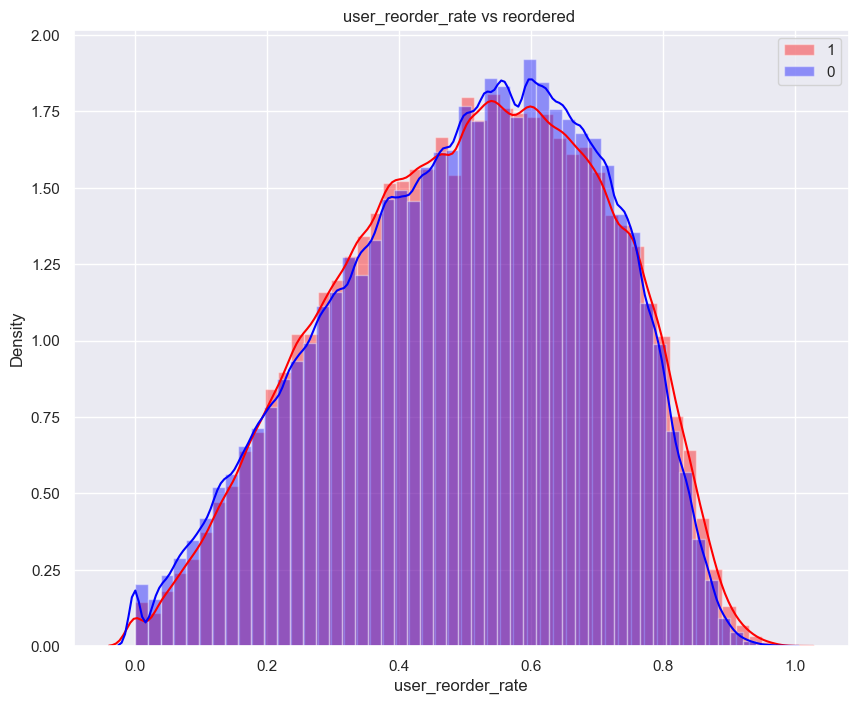

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

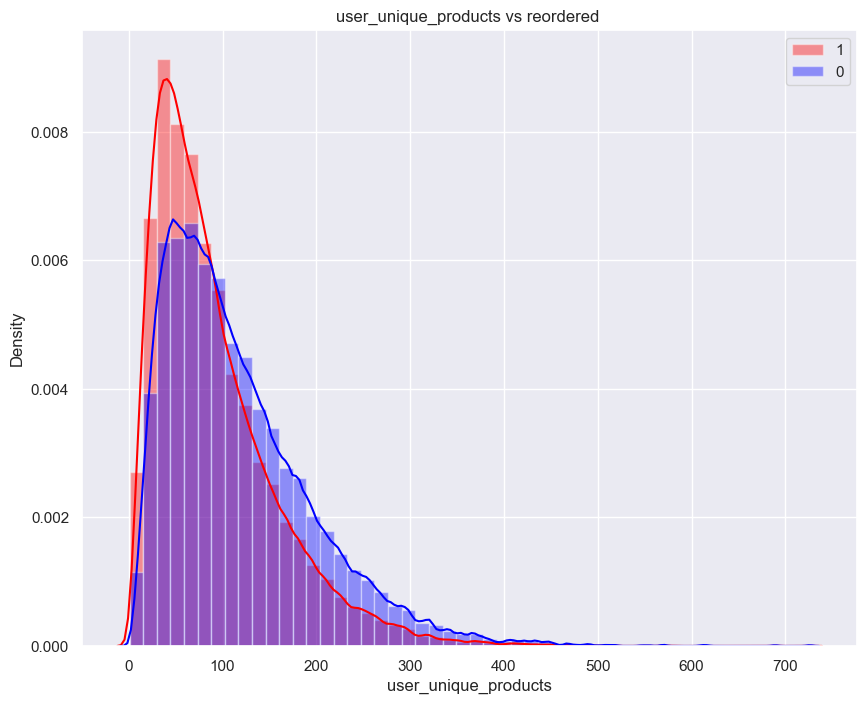

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

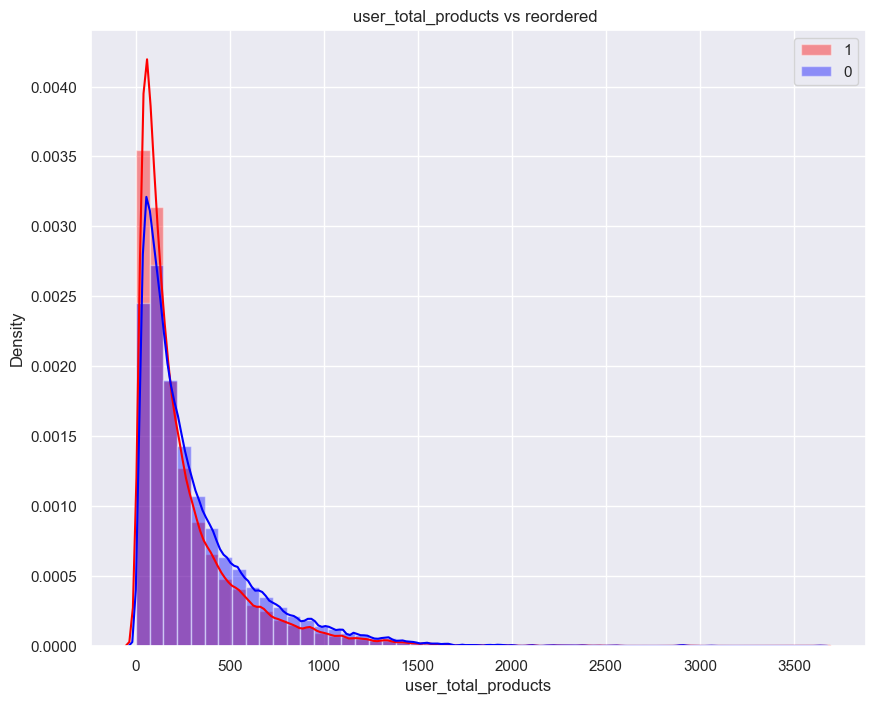

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

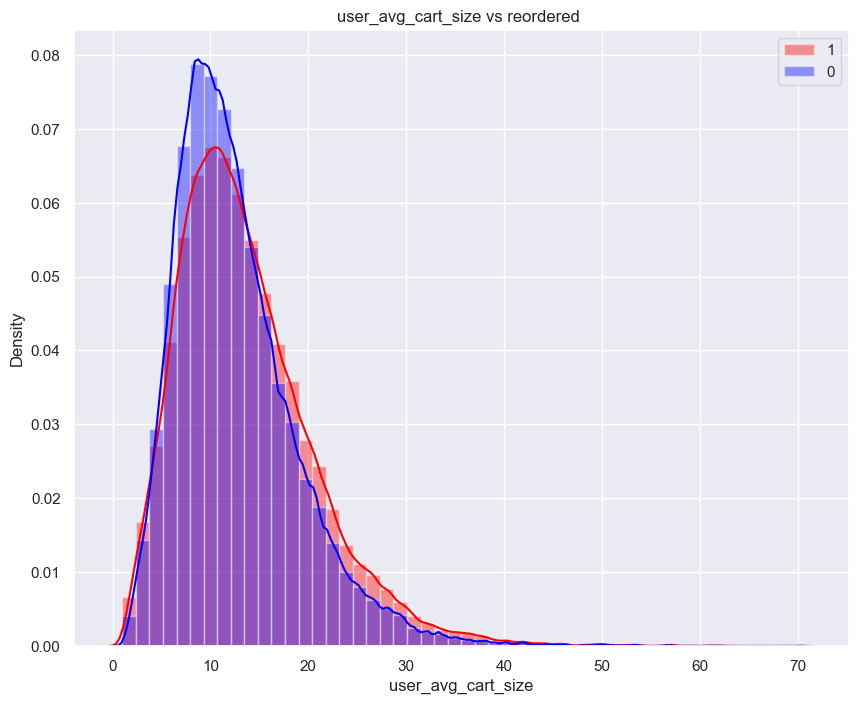

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

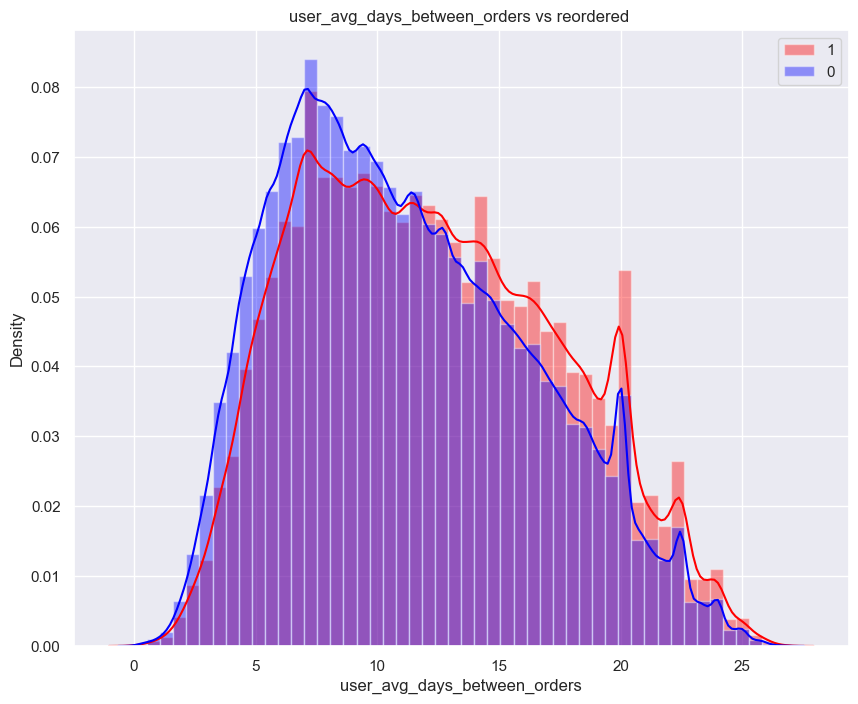

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

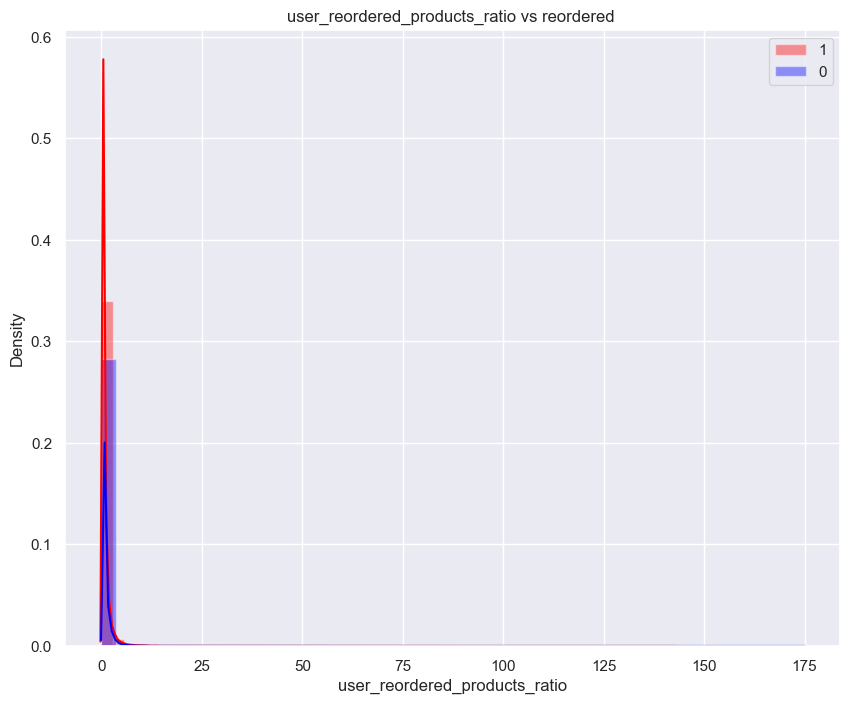

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

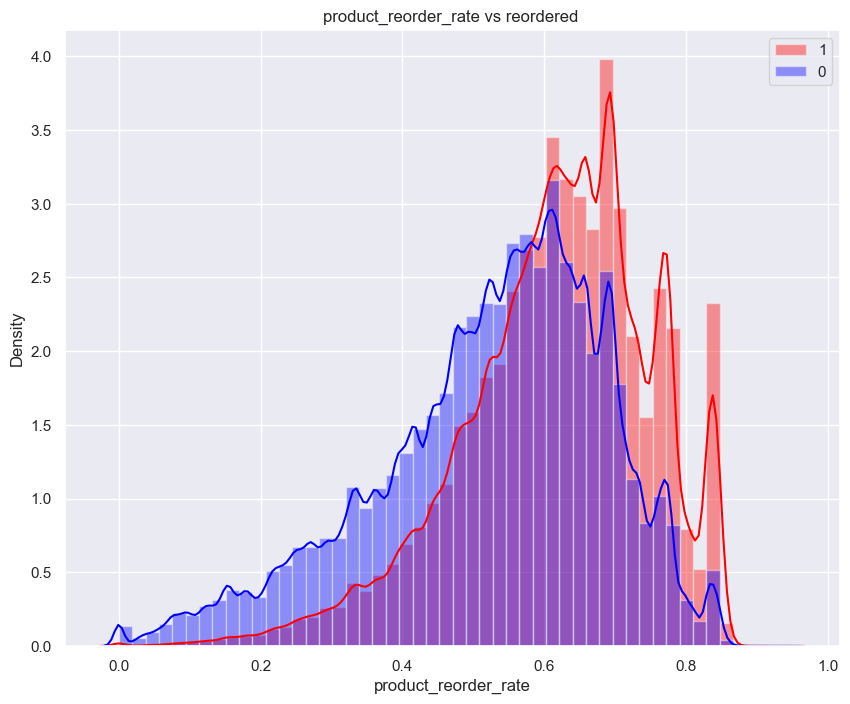

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

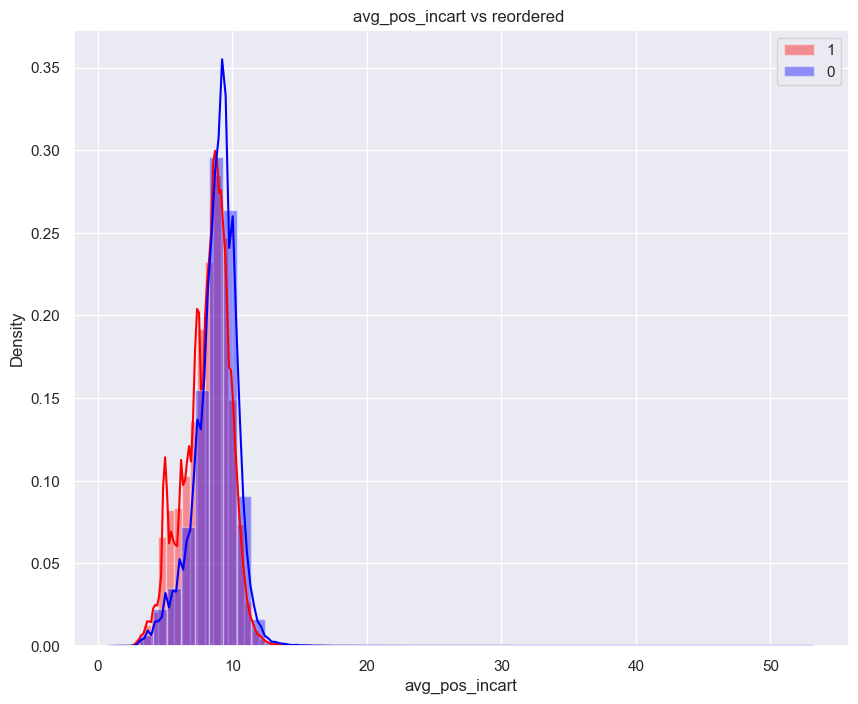

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

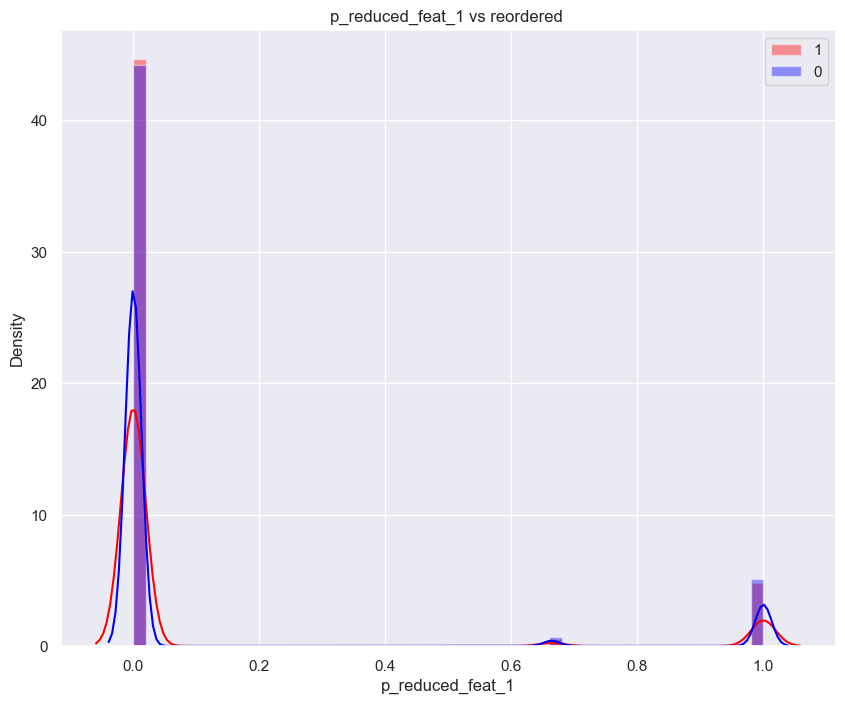

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

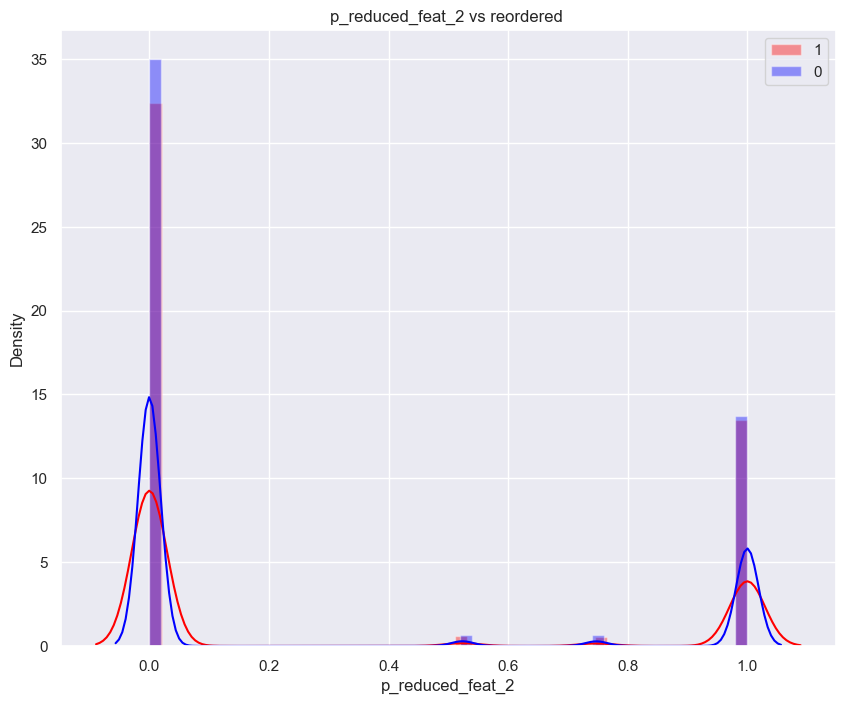

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

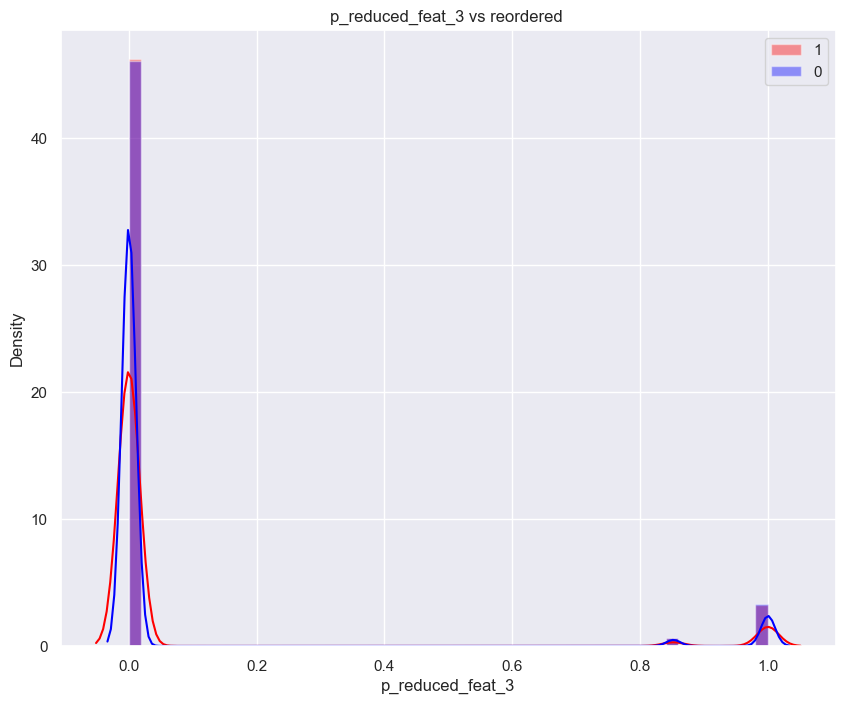

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

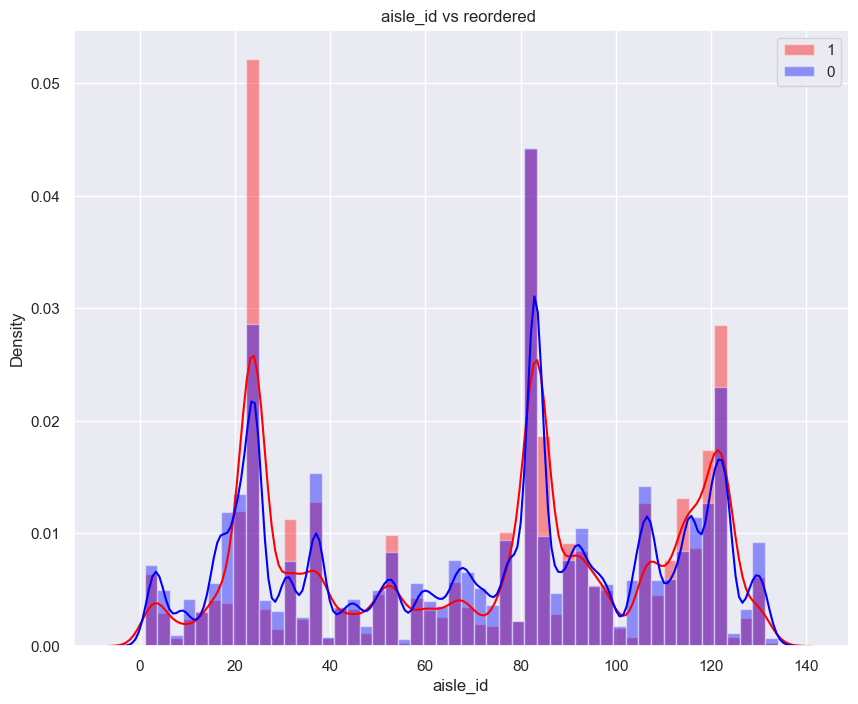

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

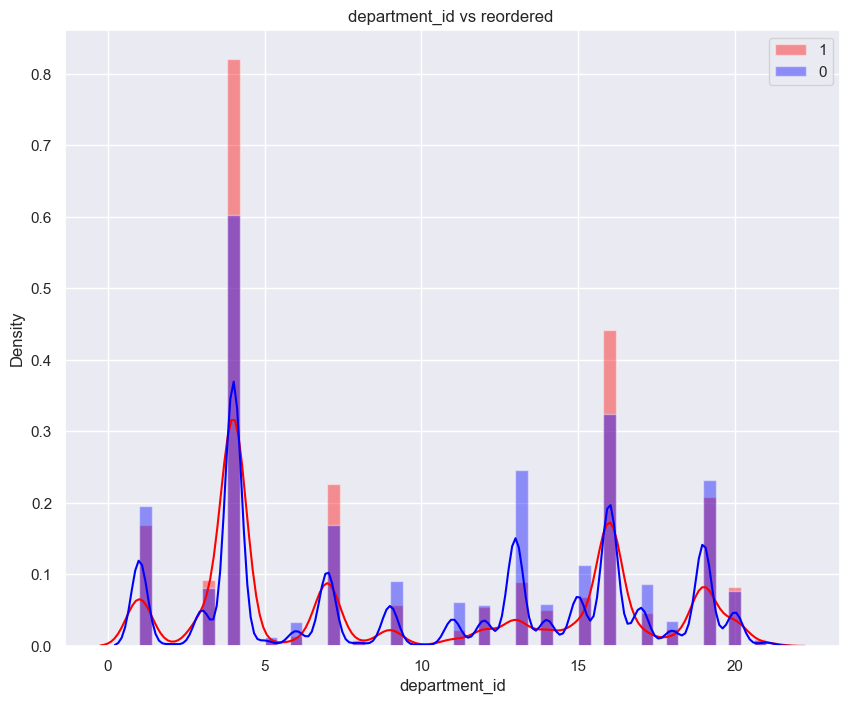

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

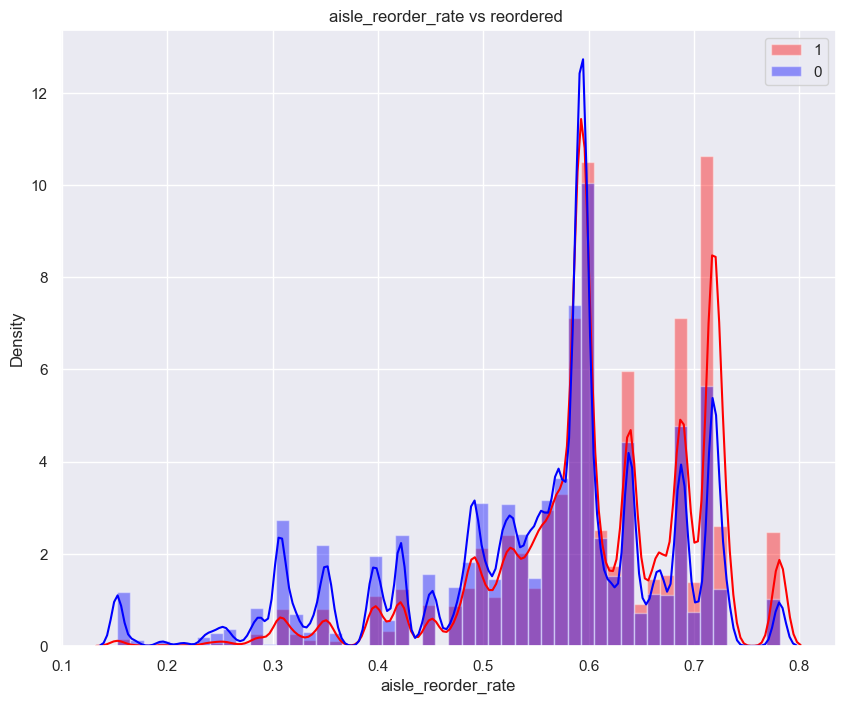

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

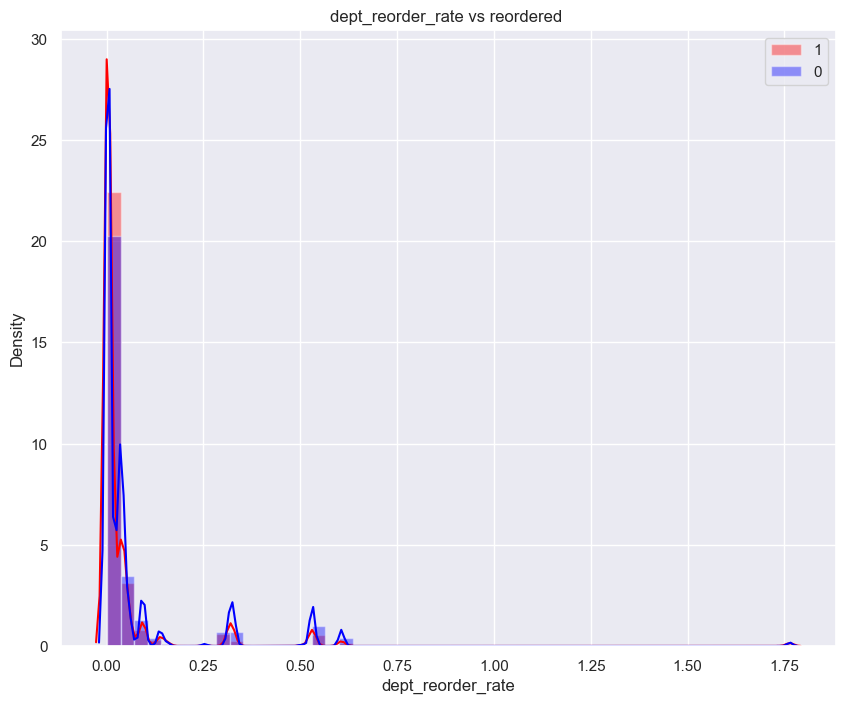

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

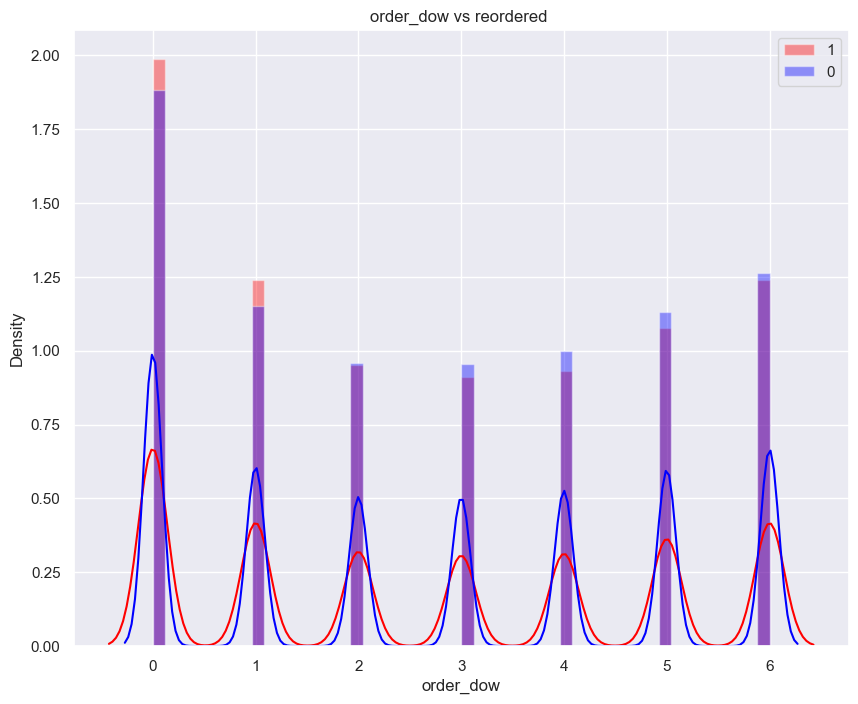

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

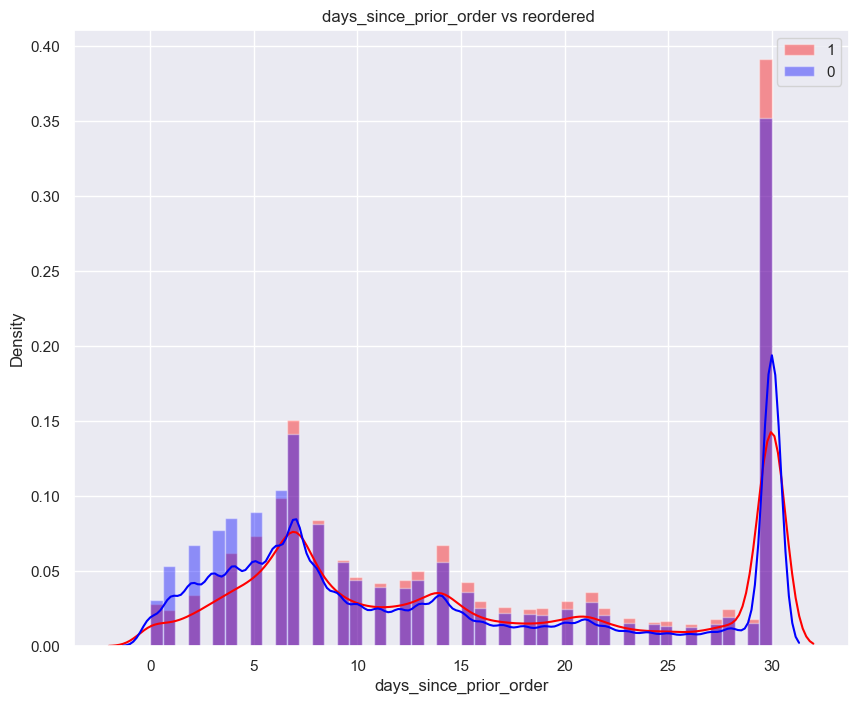

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

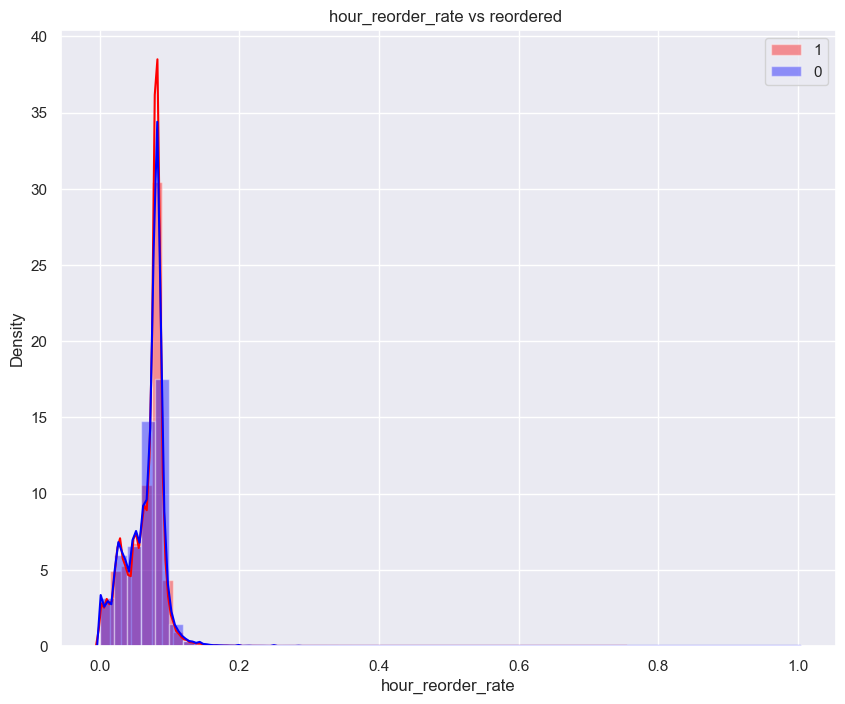

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

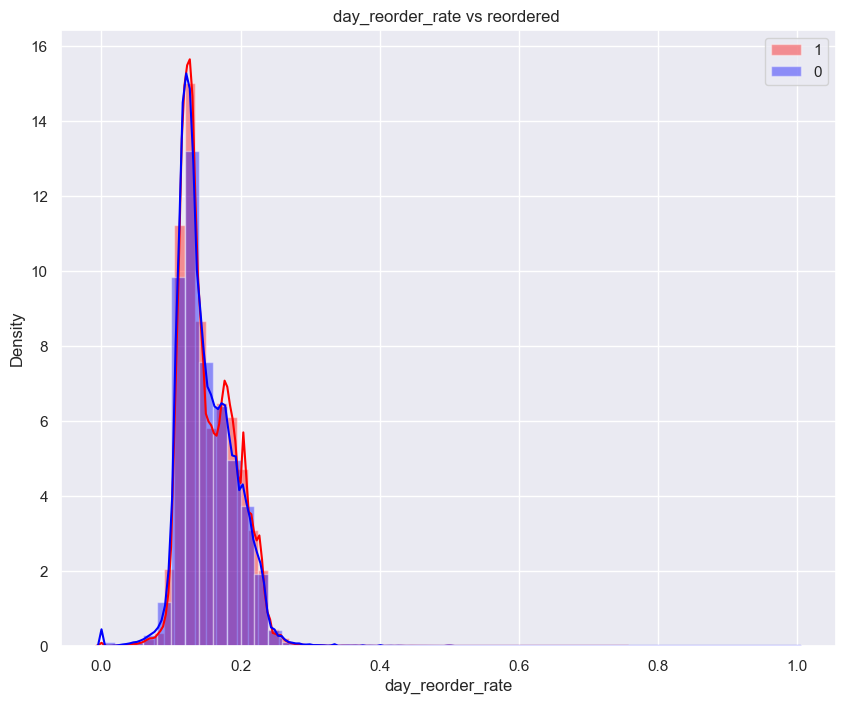

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

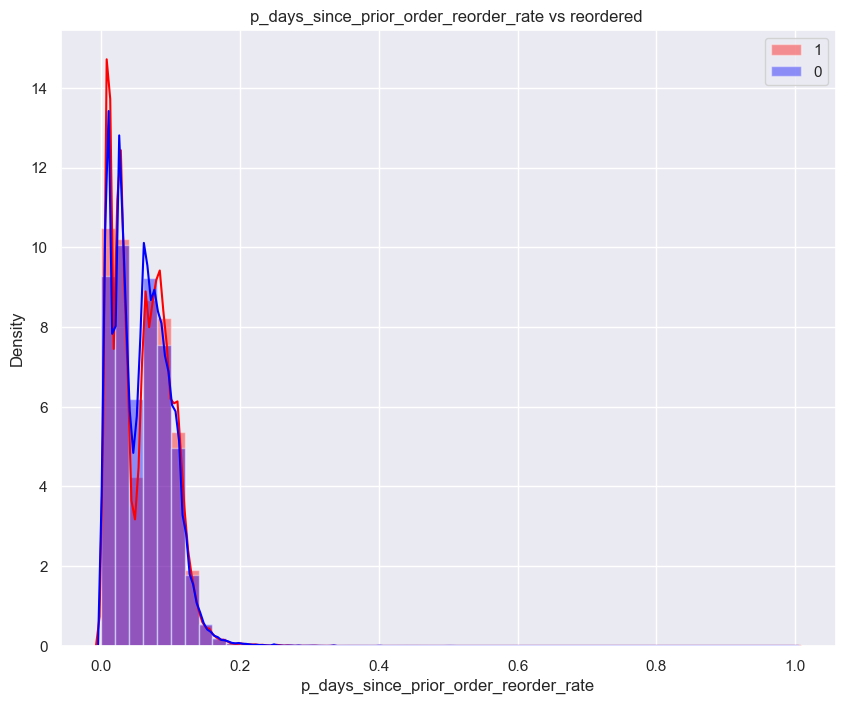

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

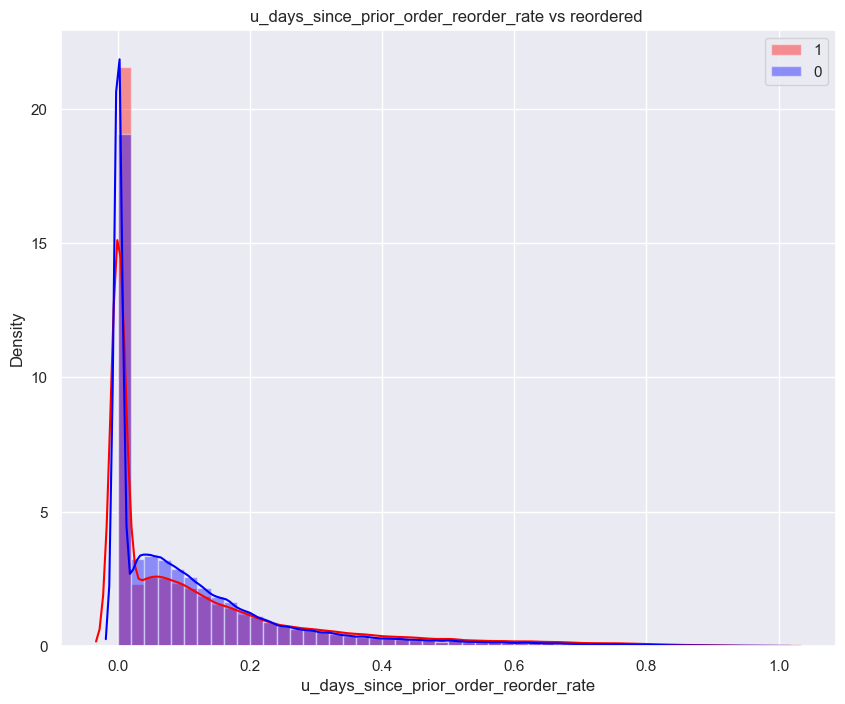

C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
C:\Users\Prashant\AppData\Local\Temp\ipykernel_4784\78160335.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['reor

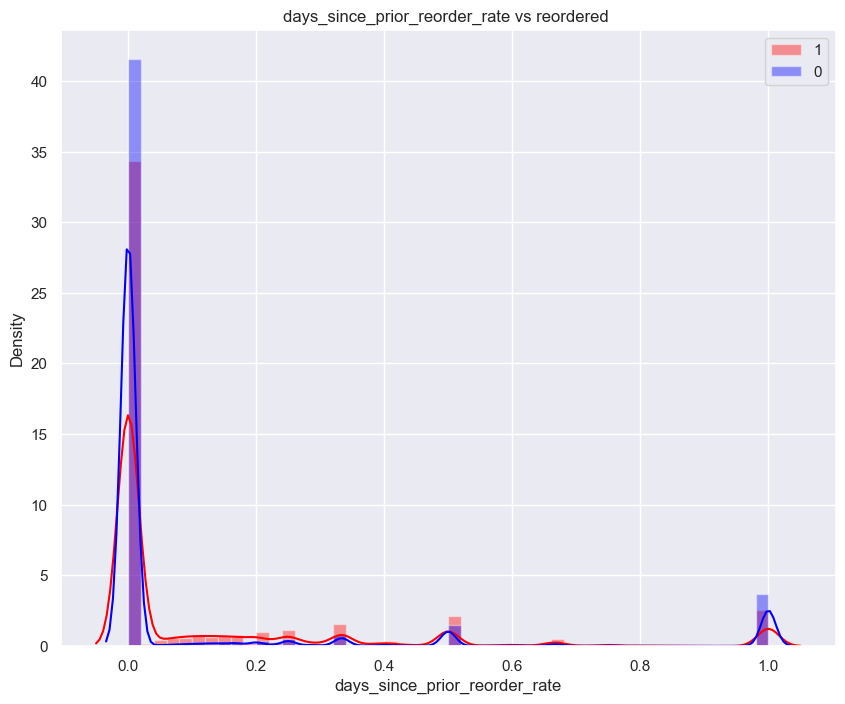

In [ ]:
# cols = [ 'u_p_order_rate', 'u_p_reorder_rate', 'u_p_avg_position', 'u_p_orders_since_last', 'max_streak', 'user_reorder_rate', 'user_unique_products', 'user_total_products', 'user_avg_cart_size', 'user_avg_days_between_orders', 'user_reordered_products_ratio', 'product_reorder_rate', 'avg_pos_incart', 'p_reduced_feat_1', 'p_reduced_feat_2', 'p_reduced_feat_3', 'aisle_id', 'department_id', 'aisle_reorder_rate', 'dept_reorder_rate', 'order_dow', 'days_since_prior_order', 'hour_reorder_rate', 'day_reorder_rate', 'p_days_since_prior_order_reorder_rate', 'u_days_since_prior_order_reorder_rate', 'days_since_prior_reorder_rate']
# for i in cols:
#     plt.figure(figsize=(10, 8))
#     sns.distplot(df[df['reordered'] == 1.0][i], label = "1", color = 'red')
#     sns.distplot(df[df['reordered'] == 0.0][i] , label = "0" , color = 'blue' )
#     plt.legend()
#     plt.title(str(i) + " vs reordered ")
#     plt.show()

Analysis
As seen from above plot,

- these features will contribute to our classification problem,
- though not heavily , but will add some value to the model.
- we can remove these features anytime , after we build our model and check feature importances

In [ ]:
gc.collect()

58177